In [6]:
import pandas as pd; import sys
import matplotlib.pyplot as plt
import numpy as np
import datetime


from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 100
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
from statsmodels.stats.weightstats import ztest, ttest_ind
from scipy import stats
from scipy.stats import ttest_ind as ttest_ind_from_scipy
import seaborn as sns
from statsmodels.stats.power import tt_ind_solve_power

### Базовые понятия

**Базовые свойства**  
Пусть x - случайная величина (СВ)  
Среднее M = M(x) = (x1 + x2 + ...) / N  
Дисперсия  $s^2= M((x - M^2)^2)$  
Дисперсия **средневыборочного (pooled)** $D(M) = D((x_1 + ... x_N) / N) = D(x) / N; s_M = s / \sqrt{N} $

In [116]:
x = stats.norm.rvs(scale=5, size=10000) # СВ
# дисперсия средневыборочного по случайной выборке длины N
N = 500 ; print(np.std([np.mean(np.random.choice(x, N)) for _ in range(1000)]), np.std(x) / np.sqrt(N))

0.21610647812355535 0.22363525338605353


**Оценки**  
Оценки параметров бывают **точечные** и **интервальные**.  
Если известно распределение F(T) и мы пытаемся оценить его параметр T по выборке X_n,  
то получаемая оценка T_n = S(X_n) может обладать рядом свойств: 
- смещение: bias = M(T_n) - T.  bias=0 -> несмещенность
- эффективность: минимальность std(T_n)
- состоятельность: при n->inf, T_n->T

In [133]:
# пример несмещенной состоятельной оценки - среднее арифметическое по выборке
# смотрим на смещение и разброс семплируемой оценки
real_mean = 10; total = stats.norm.rvs(loc=real_mean, size=1000)
def sample_mean_bias_std(total, sample_size):
    sample_mean_list = []
    for j in range(1000):
        sample_mean_list.append( np.mean(np.random.choice(total, sample_size, replace=True)) )
    return np.mean(sample_mean_list) - np.mean(total), np.std(sample_mean_list)
print(100, sample_mean_bias_std(total, sample_size=100))
print(1000, sample_mean_bias_std(total, sample_size=1000))

100 (-0.0037001439551911375, 0.09908552869811252)
1000 (-0.00044996368372807183, 0.0321970888375626)


### Распределения

**Биномиальное распределение**  
X - кол-во успехов (вероятность успеха p) среди N испытаний.  
Схема бинарная - успех или неуспех (схема Бернулли)   
$ p(X, m) = C_{Nm} * p^{N} * (1-p)^{(N-m)} $  (биномиальное распределение)

$ X = \sum_{i=0}^N B_{i} $ (B - схема Бернулли)   
B -> p=1, q=0  
M(X) = N * M(B) = pN  
D(X) = N * D(B) = N * p * (1-p)

mean =  2.0066 mean_theory =  2.0
std =  1.2702584146542781 std_theory =  1.2649110640673518


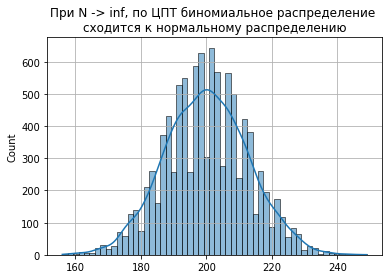

In [192]:
p=1/5; N=10; r = stats.binom.rvs(N, p, size=10000)
print('mean = ' , np.mean(r), 'mean_theory = ', N * p)
print('std = ' , np.std(r), 'std_theory = ',  np.sqrt(N * p * (1-p)))
text="""При N -> inf, по ЦПТ биномиальное распределение 
сходится к нормальному распределению"""
p=1/5; N=1000; r = stats.binom.rvs(N, p, size=10000)
sns.histplot(r, kde=True); plt.grid(); plt.title(text);

**Нормальное распределение**  
По ЦПТ сумма одинаковых распределений удовлетворяющих ряду условий сходится к нормальному распределению Гаусса  
В частности, биномиальное распределение при N->inf при p=const сходится к нормальному

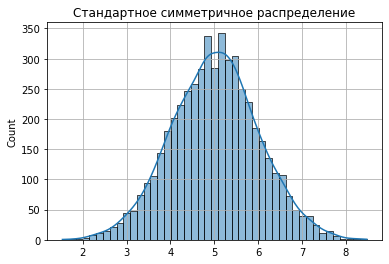

In [430]:
r = stats.norm.rvs(loc=5, scale=1, size=5000)
sns.histplot(r, kde=True); plt.grid(); plt.title('Стандартное симметричное распределение');

**Распределение Пуассона**  
Это закон редких явлений  
N->inf, p->0, pN->M=const - статистика **редких** событий с перманентным средним M  
$ P(m) = e^{-M} M^{m} / m! $ - вероятность наступления m событий  

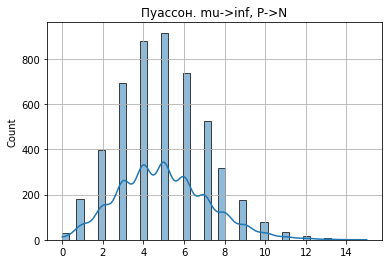

In [447]:
r=stats.poisson.rvs(mu=5, size=5000)
sns.histplot(r, kde=True); plt.grid(); plt.title('Пуассон. mu->inf, P->N');

**Хи-квадрат распределение**    
$ \chi^{2} = \sum_{i=0}^{df} N_{i}; N = N(0, 1) $  
Здесь N - нормальное распределение, df - кол-во степеней свободы  
Пример хи-квадрат распределения - дисперсия нормально распределенной величины  
При df->inf в силу ЦПТ хи-квадрат сходится к нормальному распределению

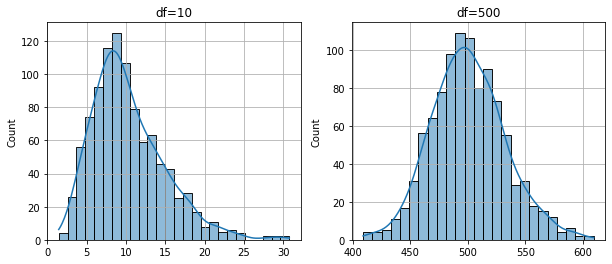

In [356]:
fig, plots = plt.subplots(1, 2, figsize=(10,4))
#
plt.sca(plots[0]); df=10
r = stats.chi2.rvs(df=df, size=1000);
sns.histplot(r, kde=True); plt.grid(); plt.title(f'df={df}');
#
plt.sca(plots[1]); df=500
r = stats.chi2.rvs(df=df, size=1000);
sns.histplot(r, kde=True); plt.grid(); plt.title(f'df={df}');

**Распределение Стьюдента**  
T_n = N(0,1) / sqrt(chi_2_n / n) # распределение Стьюдента (df=n)  
Подробнее см в стат-тесты. 

T-score, меньше которого alpha% выборки:  -1.6602343260657506


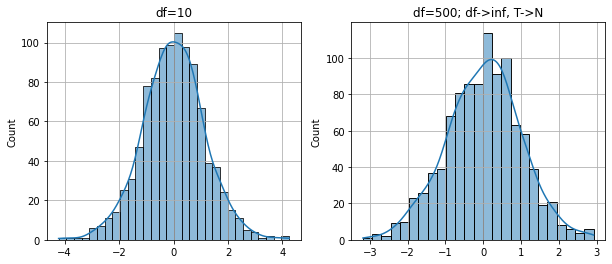

In [358]:
alpha=0.05; print('T-score, меньше которого alpha% выборки: ', stats.t.ppf(alpha, df=100)) # percent point func
fig, plots = plt.subplots(1, 2, figsize=(10,4))
#
plt.sca(plots[0]); df=10
r = stats.t.rvs(df=df, size=1000) 
sns.histplot(r, kde=True); plt.grid(); plt.title(f'df={df}')
#
plt.sca(plots[1]); df=500
r = stats.t.rvs(df=df, size=1000) # df->inf, r->N
sns.histplot(r, kde=True); plt.grid(); plt.title(f'df={df}; df->inf, T->N');

**Мультиномиальное (полиномиальное) распределение** X  
X - число повторений события A_1 имеющего вероятность p_1, A_2 (p_2) и.т.д  
Является обобщением биномиального распределения и многомерной СВ  
Пример полиномиального распределения - бутстрап (семлпирование) 

In [115]:
val_list = [1,2,3,4]
np.random.choice(val_list, replace=True) # данная случайная величина имеет мультиномиальное распределение

4

### Семплирование

**Бутстрап**  
Имеем выборку x_N распределения F(T_real). T_real - неизвестная статистика распределения  
T_pool = T(x_N) - статистика по известной выборке.  
Семплируем x_N -> x_N_boot (n_iter) -> T_boot = T(x_N_boot)  
ЦПТ бустрапа: распределение (T_pool - T_boot) стремится к (T_real - T_pool) при N -> inf.  
Это свойство в частности помогает корректировать смещение T_pool относительно T_real.  
Можно показать, что bias = T_real-T_pool ~ T_pool - T_boot.  
Метод перцентилей: доверительный интервал для T_real можно получить через np.percentile(T_boot, (a,b))

#### Пуассоновский бутстрап

**Оптимизация**  
Для выборки длины N элемент x появится в повторной выборке N_r stats.binom.rvs(N, p=1/N) раз  
При N -> inf: stats.binom.rvs(N, 1/N) -> stats.poisson.rvs(mu=N * 1/N = 1)  
Получаем возможность семплировать выборку **поэлементно** с частотами Пуассона.  
https://www.unofficialgoogledatascience.com/2015/08/an-introduction-to-poisson-bootstrap26.html

In [105]:
# полиномиальное семплирование
def mean_boot_classic(val_list, n_iter = 10**3):
    stat = []
    for j in range(n_iter):
        val_boot = np.random.choice(val_list, size=len(val_list), replace=True)
        stat.append(np.mean(val_boot))
    return np.percentile(stat, [2.5, 97.5])
# Пуассонновское семплирование для больших распределений
def mean_boot_poisson(val_list, X):
    stat = np.matmul(val_list, X) / X.sum(axis=0)        
    return np.percentile(stat, [2.5, 97.5])

# Пример
val_list = stats.norm.rvs(loc=5, scale=5, size=1000)
# можно предрасчитать заранее а также распараллелить расчет для соответствующих статистик
n_iter = 10**5
X = np.random.poisson(lam=1, size=(len(val_list), n_iter))  

In [108]:
%%timeit
mean_boot_classic(val_list, n_iter=10**5)

2.49 s ± 64.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [110]:
%%timeit
mean_boot_poisson(val_list, X)

576 ms ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [113]:
mean_boot_classic(val_list, n_iter=10**5), mean_boot_poisson(val_list, X)

(array([4.49093124, 5.09538652]), array([4.48996628, 5.09333302]))

#### Бутстрап на малых выборках, смещение

**Смещение и разброс оценок**  
Пусть оцениваем параметр T распределения F(T) по выборке X_n.  
T - медиана, среднее и пр. Базовая оценка T(X_n)    
Семплируем X_n ->  T(X_n_iter) -> T_boot_list  

При n_iter -> inf:  
np.std(T_boot_list) -> const > 0 (разброс).  
bias = np.mean(T_boot_list) - T(X_n) -> const (смещение)

Скорректированная оценка среднего:  
T_mean_boot_estimate_cor = T(X_n) - bias = 2 * T(X_n) - np.mean(T_boot_list)

 

Подробнее см. https://math.montana.edu/jobo/thainp/boot.pdf  
https://garstats.wordpress.com/2018/01/23/bias-correction/

In [417]:
total = stats.lognorm.rvs(loc=0, s=2, size=100000)
stat, stat_m = [], []
N_sample = 10
for _ in range(10000):
    # выборка из total
    sample = np.random.choice(total, N_sample, replace=True)   
    stat.append(np.mean(sample))
    stat_m.append(np.median(sample))

# корректировка смещения выборочного среднего через бутстрап 
print(f"""mean_total = {np.mean(total)}
mean_sample = {np.mean(stat)}
median_total = {np.median(total)}
median_sample = {np.mean(stat_m)}
mean - несмещенная оценка, median - смещенная при малых N_sample""")

mean_total = 7.190352413563664
mean_sample = 7.16594748125934
median_total = 0.9757115776494678
median_sample = 1.3709282572197792
mean - несмещенная оценка, median - смещенная при малых N_sample


In [428]:
total = stats.lognorm.rvs(loc=0, s=1, size=100000)
stat_m, stat_m_cor = [], []
N_sample = 10
# рост кол-ва выборок дает ассимптотику для корректировки смещения через boot
for _ in range(10000):
    # выборка из total
    sample = np.random.choice(total, N_sample, replace=True)   
    stat_m.append(np.median(sample))
    bias = np.mean([np.median(np.random.choice(sample, len(sample), replace=True)) for _ in range(100)]) - np.median(sample)
    stat_m_cor.append(np.median(sample) - bias)

# корректировка смещения выборочного среднего через бутстрап 
# чем больше выборок - тем статистически точнее коррекция
print(f"""median_total = {np.median(total)}
median_sample = {np.mean(stat_m)}
median_sample_bias_cor = {np.mean(stat_m_cor)}""")


median_total = 0.9928854657089206
median_sample = 1.0766343367310711
median_sample_bias_cor = 0.9867396787122478


In [467]:
total = stats.lognorm.rvs(loc=0, s=1, size=10000) # распределение с перекосом
s1, s2 = [], []
for _ in range(500):
    N_sample = 10
    sample = np.random.choice(total, N_sample, replace=True) # имеем эту выборку
    def get_boot(sample, n_iter=200):
        boot_stat = [np.median(np.random.choice(sample, len(sample), replace=True)) for _ in range(n_iter)]
        bias = np.mean(boot_stat) - np.median(sample)
        conf = np.percentile(boot_stat, [2.5, 97.5])
        # смещения boot относительно sample и sample относительно total
        conf_cor = conf - 2 * bias 
        return conf, conf_cor
    conf, conf_cor = get_boot(sample)
    s1.append(abs(np.median(total)) - (conf_cor[1] + conf_cor[0]) / 2)
    s2.append(abs(np.median(total)) - (conf[1] + conf[0]) / 2)
# статистика по s1 ближе к реальной
np.mean(s1), np.std(s1), np.mean(s2), np.std(s2)

(-0.26353154434308346,
 0.4646867870004884,
 -0.4632303880512882,
 0.6030923721165049)

In [ ]:
# todo
# https://www.youtube.com/watch?v=p_5YzShN4sg
# децильное распределение val_list1, val_list2 на основании бутстрапа
# N-й дециль -> доверительный интервал , контрольное значение 

### Стат-тесты

**Z-score** - случайная величина с матожиданием 0 и дисперсией 1    
Для любой СВ X: Z(X) = (X - M(X)) / std(X)  

**T-test (Стьюдент)**  
Сравниваем средние двух выборок X1 и X2  
M1p, M2p - средневыборочные из СВ X1, X2  
Если H0: M1=M2, то Z(M2p-M1p) = (M2p - M1p) / std(M2p - M1p) = T-score  
T = (M2p - M1p) / sqrt( D(X2)/N2 + D(X1)/N1 )  # дисперсия средневыборочного  
T ~ N / sqrt(chi_2) ~ T-dist  
T_n = N(0,1) / sqrt(chi_2_n / n) # распределение Стьюдента (df=n)  

**Z-test**  
1) При n->inf D(x2), D(x1) -> const (генеральная совокупность)  
T = (M2p - M1p) / const ~ N  
2) T-dist (N->inf) -> N  
Статистика для разности средних для больших выборок стремится к нормальной

**Доверительный интервал**  
Это интервальная оценка параметра - например, разности средних выборок  
Такой интервал, что при данном распределении разности средних (1-alpha)% приходится на интервал  
Если разность распределена по Стьюденту, то (M2-M1)_conf = (M2-M1) +- T.ppf(alpha/2) * (std_pooled_2_1)  

**Ширина интервала от размера выборки**  
conf_w = T.ppf(alpha/2) * (std_pooled_2_1) = T.ppf(alpha/2) * $ \sqrt{( {s1}^{2} / n1 + {s2}^{2} / n2)} $  
s1, s2 - оценки дисперсий в сравниваемых выборках (используем для получения оценки дисперсии средневыборочного)  
При n1=n2=n получаем conf_w ~ 1/sqrt(n)

In [ ]:
# общее по стат-тестам вкл p_value и мощность

In [195]:
# Стат-тесты
def mean_ttest(list_1, list_2, significance = 0.05):
    """в пределе T-распределение сходится к Z-распредлению"""
    T, p_value, _ = ttest_ind(list_2, list_1, alternative='larger', usevar='unequal')
    if p_value <= significance / 2:
        decision = 'M(list_2) > M(list_1)'
    elif p_value >= 1 - significance / 2:
        decision = 'M(list_2) < M(list_1)'
    else:  
        decision = 'M(list_2) ~ M(list_1)'
    return p_value, np.mean(list_2) - np.mean(list_1), decision

# Доверительные интервалы
def mean_diff_confint_boot(list_1, list_2, significance = 0.05):
    stat_list = []
    significance = 100 * significance
    for j in range(3000):
        list_1_boot = np.random.choice(list_1, len(list_1), replace=True)
        list_2_boot = np.random.choice(list_2, len(list_2), replace=True)
        stat_list.append(np.mean(list_2_boot) - np.mean(list_1_boot))
    return np.percentile(stat_list, [significance / 2, 100 - significance / 2])

def mean_diff_confint(list_1, list_2, significance = 0.05):
    mean_1, mean_2 = np.mean(list_1), np.mean(list_2)    
    var = np.std(list_1) ** 2 / len(list_1) + np.std(list_2) ** 2 / len(list_2)
    se = np.sqrt(var)
    z = stats.t.ppf(1 - significance / 2, df=(len(list_1) + len(list_2) - 2))
    return (mean_2 - mean_1) + np.array([-1, 1]) * z * se

def proportion_diff_confint(count1, nobs1, count2, nobs2, significance = 0.05):
    conv1 = count1 / nobs1; conv2 = count2 / nobs2
    var = conv1 * (1 - conv1) / nobs1 + conv2 * (1 - conv2) / nobs2 
    se = np.sqrt(var)
    z = stats.t.ppf(1 - significance / 2, df=(nobs1 + nobs2 - 2))
    return (conv2 - conv1) + np.array([-1, 1]) * z * se

# для оценки абсолютной величины
def mean_confint_boot(list_1, significance = 0.05):
    stat_list = []
    significance = 100 * significance
    for j in range(3000):
        list_1_boot = np.random.choice(list_1, len(list_1), replace=True)
        stat_list.append(np.mean(list_1_boot))
    return np.percentile(stat_list, [significance / 2, 100 - significance / 2])

In [187]:
# ПРОВЕРКА ТЕСТОВ
# дискретные величины (пропорции)
count1 = 1235; nobs1=4500
count2 = 956; nobs2=3000
list_1_d = [1] * count1 + [0] * (nobs1 - count1)
list_2_d = [1] * count2 + [0] * (nobs2 - count2)
# непрерывные величины (тест на средние)
list_1_c = stats.norm.rvs(size=2000, loc=0, scale=1)
list_2_c = stats.norm.rvs(size=2000, loc=1, scale=2)
# тестируем подходы
print('boot d' , mean_diff_confint_boot(list_1_d, list_2_d))
print('classic d' , mean_diff_confint(list_1_d, list_2_d))
print('boot c' , mean_diff_confint_boot(list_1_c, list_2_c))
print('classic c' , mean_diff_confint(list_1_c, list_2_c))
# проверка совпадения оценок по доверительным интервалам и стат-тестам
for j in range(1425, 1500, 25):    
    count1 = int(0.2 * j); nobs1=j
    count2 = int(0.23 * j); nobs2=j
    list_control = [1] * count1 + [0] * (nobs1 - count1)
    list_exp = [1] * count2 + [0] * (nobs2 - count2)
    _, _, dec = mean_ttest(list_control, list_exp)
    conf = mean_diff_confint(list_control, list_exp)    
    print(j, dec, conf)
# ширина доверительного интервала от размера выборки ~ 1/sqrt(N)
# если сейчас имеем интервал conf_w на N данных, то для сужения в k раз нужно k^2 * N данных
for N in [100, 500, 1000, 5000]:
    list_1 = stats.norm.rvs(size=N, loc=0, scale=1)
    list_2 = stats.norm.rvs(size=N, loc=1, scale=2)
    conf = mean_diff_confint(list_1, list_2) 
    conf_w = conf[1] - conf[0]
    print(N, 'conf_w ', conf_w)

boot d [0.02344167 0.06633333]
classic d [0.02305277 0.06539168]
boot c [0.83289245 1.02932401]
classic c [0.83011873 1.0321614 ]
1425 M(list_2) ~ M(list_1) [-0.00067173  0.0596191 ]
1450 M(list_2) ~ M(list_1) [-0.00023338  0.05954372]
1475 M(list_2) > M(list_1) [0.00019238 0.05946864]
100 conf_w  0.8923917344981498
500 conf_w  0.378783614657745
1000 conf_w  0.2771781518998082
5000 conf_w  0.12378476298420882


**Тест Барлетта**  
Критерий Барлетта при условии нормальности распределения СВ  
позволяет проверять гипотезу о равенстве их дисперсий.  
При p_val > alpha отвергаем гипотезу о равенстве, наоборот - принимаем.

In [575]:
a1 = stats.norm.rvs(loc=5, scale=1, size=100)
a2 = stats.norm.rvs(loc=10, scale=1, size=100)
b1 = stats.norm.rvs(loc=5, scale=1, size=100)
b2 = stats.norm.rvs(loc=10, scale=1.5, size=100)
stats.bartlett(a1, a2), stats.bartlett(b1, b2)

(BartlettResult(statistic=1.9305854152740385, pvalue=0.16469441175409116),
 BartlettResult(statistic=11.85573841202956, pvalue=0.0005748393803078713))

**Критерий согласия**  
Критерий проверки соответствия распределения заданной форме (теоретической или экспериментальной)  

**chi-2 критерий**  
TODO - описать

**Критерий Колмогорова**  
Сравниваем распределения F1 и F2 (F2 - может быть теоретическим или экспериментальным)  
Статистика Колмогорова D_n=max(abs(F2_n - F1_n)); D_n -> Dist_Колмогорова при n->inf  

### Длина выборок

**MDE**  
alpha - ошибка 1го рода - вероятность ложного срабатывания теста  
betta - ошибка 2го рода - вероятность не-срабатывания теста при реальном различии  
power = 1-betta - мощность теста. При фикс alpha чем выше - тем лучше.  

Зная ошибки и параметры контрольной выборки в предположении можно для  
минимального ожидаемого эффекта (minimal effect size) оценить размер выборок.  

Если std_exp ~ std_control:
effect_size = mean_delta / std_control  
В общем случае:
effect_size = mean_delta / std_c TODO - разобраться.   


In [551]:
# Поиск MDE по сделанным измерениям
# заданы параметры метрики в контрольной выборке:
control_loc = 10
control = stats.norm.rvs(scale=1, loc=control_loc, size=1000)
# для фиксированных ошибок 1го (alpha) и 2го (1-power) рода определяем какое изменение метрики (минимальное) сможем задетектировать
power = 0.8 # допускаем серое, когда зеленое в 20% случаев
effect_size = tt_ind_solve_power(nobs1=len(control), alpha=0.05, power=power, ratio=1, alternative='two-sided')
exp_mean_thr = control_loc + effect_size * np.std(control)
# проверяем статистическую нагрузку на тест:
stat = []
for _ in range(5000):
    control = stats.norm.rvs(scale=1, loc=control_loc, size=1000)
    exp = stats.norm.rvs(scale=1, loc=exp_mean_thr, size=1000)
    a,b = mean_diff_confint(control, exp)
    if a>0:
        stat.append(1)
    else:
        stat.append(0)
np.mean(stat) # доля прокрасов по доверительному интервалу

0.8098

In [566]:
control_loc = 10
control = stats.norm.rvs(scale=1, loc=control_loc, size=1000)
mean_delta = 0.05 # минимальная точность измерения

effect_size = mean_delta / np.std(control)
nobs1 = tt_ind_solve_power(effect_size=effect_size, alpha=0.05, power=0.8, ratio=1, alternative='two-sided')
print('N_control/exp', nobs1)
# nobs1 - сколько семплов на ветку для различимости заданного эффекта с фикс ошибками
# проверяем статистическую нагрузку на тест:
stat = []
for _ in range(5000):
    control = stats.norm.rvs(scale=1, loc=control_loc, size=int(nobs1))
    exp = stats.norm.rvs(scale=1, loc=control_loc+mean_delta, size=int(nobs1))
    a,b = mean_diff_confint(control, exp)
    if a>0:
        stat.append(1)
    else:
        stat.append(0)
np.mean(stat) # доля прокрасов по доверительному интервалу

N_control/exp 6303.3579482756695


0.8008

In [567]:
# TODO - разобраться с уравнением tt_ind_solve_power

### Выбросы

In [405]:
def mean_hist(val_list):
    """распределение средневыборочного с тестом на нормальность"""
    boot_stat = []
    for j in range(3000):
        boot_stat.append(np.mean(np.random.choice(val_list, len(val_list), replace=True)))
    loc, scale = np.mean(boot_stat), np.std(boot_stat)
    _, p_val = stats.kstest(boot_stat, 'norm', args=(loc, scale)) # определяем, является ли нормальным распределением
    sns.histplot(boot_stat, kde=True); plt.grid(); plt.title(f'KS_norm: p_val = {np.round(p_val, 3)}, moment_3={int(stats.moment(val_list, 3))}')
    
def filt_percentile(val_list, perc_thr=95):
    """Фильтрация выбросов по перцентилям значений"""
    val = np.array(val_list)
    return val[val < np.percentile(val, perc_thr)]

**Центральная предельная теорема**  
Центра́льные преде́льные теоре́мы (ЦПТ) — класс теорем в теории вероятностей, утверждающих, что сумма достаточно большого количества слабо зависимых случайных величин,  
имеющих примерно одинаковые масштабы (ни одно из слагаемых не доминирует, не вносит в сумму определяющего вклада), имеет распределение, близкое к нормальному  
- случайные величины имеют сходные типы распределений
- распределения имеют конечные значения матожидания и дисперсии
- удельный вес каждой СВ стремится к нулю с ростом выборки  

Выбросы как раз нарушают третье условие ЦПТ. Например, удельный вес выбросов начинает искажать тенденцию среднего  
По идее, мы можем фильтровать выбросы до тех пор, пока средневыборочное не станет нормально распределенным (чтобы применять критерии)  

В формулировке Ляпунова необходимо, чтобы для выборки с конечными mean и std также стремился к нулю stats.moment(val_list, moment=3)  
Вклад разности среднего и конкретного значения должен стремиться к нулю с ростом выборки 

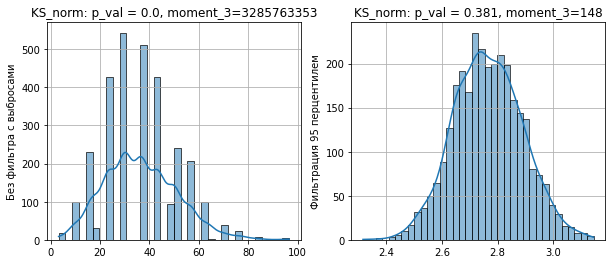

In [406]:
# Эмуляция покупок с выбросами и частыми нулевыми чеками
# если имеется редкая отличающаяся группа (вроде c), то ЦПТ нарушается
# и средневыборочное становится не нормальным
a = [0] * 1000 # нулевые чеки
b = stats.norm.rvs(loc=10, scale=5, size=500) # нормальное распределение среди купивших
c = [10000] * 5 # выбросы
r = np.hstack((a, b, c))
fig, plots = plt.subplots(1, 2, figsize=(10,4))
plt.sca(plots[0])
mean_hist(r); plt.ylabel('Без фильтра с выбросами')
plt.sca(plots[1])
mean_hist(filt_percentile(r)); plt.ylabel('Фильтрация 95 перцентилем');

In [407]:
# TODO
# подразобраться еще про момент-3 и вклад в выбросы

In [ ]:
# TODO - разобраться с IQR

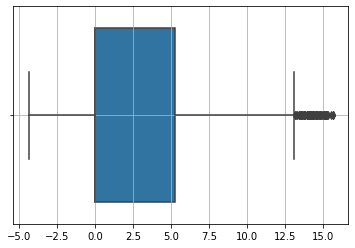

In [422]:
sns.boxplot(x=filt_percentile(r)); plt.grid()

### Регрессия

In [ ]:
 На примере с эластичностью - попробовать разобраться